# 机器学习练习 5 - 偏差和方差

In [1]:
import numpy as np
import scipy.io as scio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data():
    d = scio.loadmat('ex5data1.mat')
    return map(np.ravel,[d['X'],d['y'],d['Xval'],d['yval'],d['Xtest'],d['ytest']])

In [3]:
X,y,Xval,yval,Xtest,ytest = load_data()

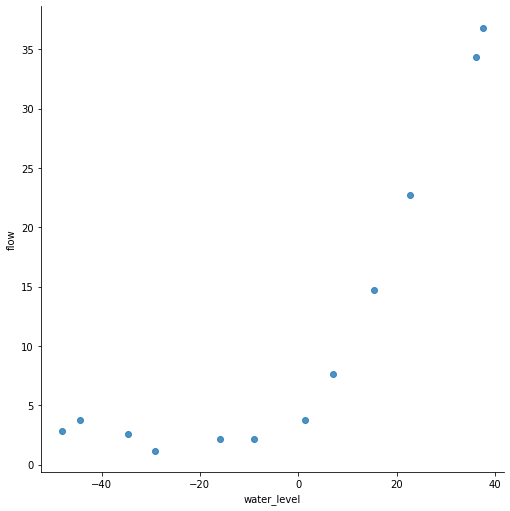

In [4]:
df = pd.DataFrame({'water_level':X,'flow':y })
sns.lmplot(x='water_level',y = 'flow',data=df,fit_reg=False,height=7)
plt.show()

In [5]:
X,Xval,Xtest = [np.insert(x.reshape(x.shape[0],1),0,np.ones(x.shape[0]),axis=1) for x in (X,Xval,Xtest)]

## 代价函数

In [6]:
def cost(theta,X,y):
    m = X.shape[0]
    
    inner = X @ theta - y
    
    square_sum = inner.T @ inner
    cost = square_sum/(2*m)
    return cost

In [7]:
theta = np.ones(X.shape[1])
cost(theta,X,y)

303.9515255535976

## 梯度

In [8]:
def gradient(theta,X,y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta -y)
    return inner / m

In [9]:
gradient(theta,X,y)

array([-15.30301567, 598.16741084])

## 正则化梯度

In [10]:
def regularized_gradient(theta,X,y,l=1):
    m = X.shape[0]
    
    regularized_term = theta.copy()
    regularized_term[0] = 0
    regularized_term = (l/m) * regularized_term
    
    return gradient(theta,X,y) + regularized_term

In [11]:
regularized_gradient(theta, X, y,0)

array([-15.30301567, 598.16741084])

## 拟合数据

In [12]:
def linear_regression_np(X,y,l=1):
    theta = np.ones(X.shape[1])
    res = opt.minimize(fun = regularized_cost,
                       x0 = theta,
                       args = (X,y,l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp':True})
    return res

In [13]:
def regularized_cost(theta, X, y,l=1):
    m = X.shape[0]
    
    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()

    return cost(theta, X, y) + regularized_term

In [14]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')
final_theta

array([13.08790348,  0.36777923])

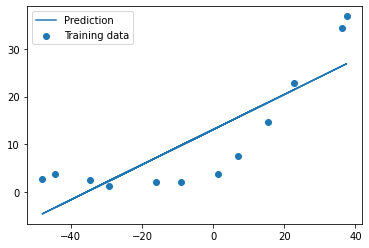

In [15]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:,1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [16]:
training_cost, cv_cost = [], []

In [17]:
m = X.shape[0]
for i in range(1,m+1):
    res = linear_regression_np(X[:i,:],y[:i],l=0)
    
    tc = regularized_cost(res.x,X[:i,:],y[:i],l = 0)
    cv = regularized_cost(res.x,Xval,yval,l = 0)
    
    training_cost.append(tc)
    cv_cost.append(cv)

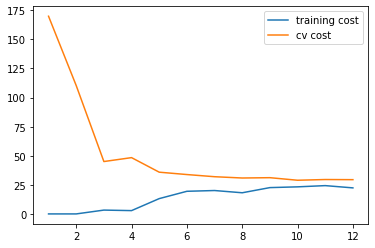

In [18]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

这个模型拟合不太好, 欠拟合了

## 创建多项式特征

In [19]:
def prepare_poly_data(*args,power):
    
    def prepare(x):
        df = poly_features(x,power)
        ndarr = normalize_feature(df).values
        
        return np.insert(ndarr,0,np.ones(ndarr.shape[0]),axis=1)
    return [prepare(x) for x in args]

In [20]:
def poly_features(x,power,as_ndarray=False):
    data = {'f{}'.format(i): np.power(x,i) for i in range(1,power+1)}
    df = pd.DataFrame(data)
    
    return df.values if as_ndarray else df

In [21]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [22]:
poly_features(X, power=3,as_ndarray=True)

array([[-1.59367581e+01,  2.53980260e+02, -4.04762197e+03],
       [-2.91529792e+01,  8.49896197e+02, -2.47770062e+04],
       [ 3.61895486e+01,  1.30968343e+03,  4.73968522e+04],
       [ 3.74921873e+01,  1.40566411e+03,  5.27014222e+04],
       [-4.80588295e+01,  2.30965109e+03, -1.10999128e+05],
       [-8.94145794e+00,  7.99496701e+01, -7.14866612e+02],
       [ 1.53077929e+01,  2.34328523e+02,  3.58705250e+03],
       [-3.47062658e+01,  1.20452489e+03, -4.18045609e+04],
       [ 1.38915437e+00,  1.92974986e+00,  2.68072045e+00],
       [-4.43837599e+01,  1.96991814e+03, -8.74323736e+04],
       [ 7.01350208e+00,  4.91892115e+01,  3.44988637e+02],
       [ 2.27627489e+01,  5.18142738e+02,  1.17943531e+04]])

## 准备多项式回归数据

In [23]:
def normalize_feature(df):
    return df.apply(lambda column : (column - column.mean())/column.std())

In [24]:
X_poly, Xval_poly, Xtest_poly= prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## 画出学习曲线

In [25]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]

    for i in range(1, m + 1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l)
        # remember, when you compute the cost here, you are computing
        # non-regularized cost. Regularization is used to fit parameters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)

        training_cost.append(tc)
        cv_cost.append(cv)
    plt.plot(np.arange(1, m + 1), training_cost, label='training cost')
    plt.plot(np.arange(1, m + 1), cv_cost, label='cv cost')
    plt.legend(loc=1)
    return res

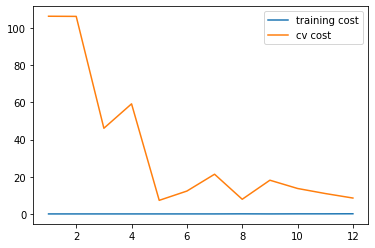

In [26]:
res = plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

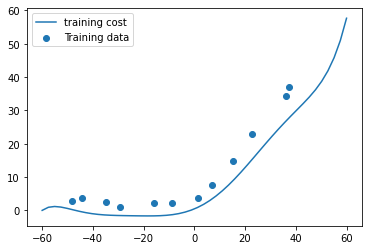

In [27]:
plt.scatter(X, y, label="Training data")
x = np.linspace(-60,60)
xploy= prepare_poly_data(x, power=8)

plt.plot(x,(xploy @ res.x).reshape(-1), label='training cost')
plt.legend(loc=2)
plt.show()

你可以看到训练的代价太低了，不真实. 这是 过拟合了

## try 𝜆=1

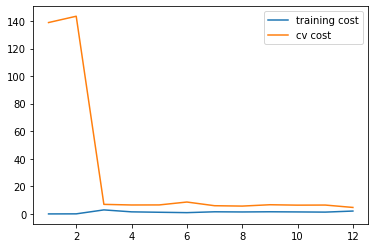

In [28]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

训练代价增加了些，不再是0了。 也就是说我们减轻过拟合

## try 𝜆=100

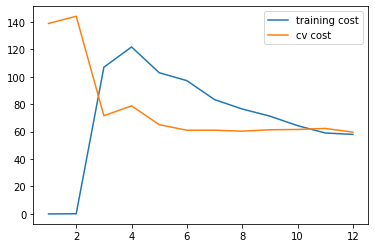

In [29]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

太多正则化了.
变成 欠拟合状态

## 找到最佳的 𝜆

In [30]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [31]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

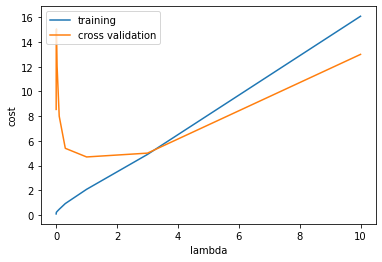

In [32]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross validation')
plt.legend(loc=2)

plt.xlabel('lambda')

plt.ylabel('cost')
plt.show()

In [33]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [34]:
# use test data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.804375286491785
test cost(l=0.001) = 10.911365745177878
test cost(l=0.003) = 11.265060784108712
test cost(l=0.01) = 10.879143763702967
test cost(l=0.03) = 10.022378551698187
test cost(l=0.1) = 8.631776100446476
test cost(l=0.3) = 7.3365081011786275
test cost(l=1) = 7.466282452677015
test cost(l=3) = 11.643940740451052
test cost(l=10) = 27.715080273166386


调参后， 𝜆=0.3 是最优选择，这个时候测试代价最小